In [16]:
import pandas as pd
import re
import datetime
import json
import itertools
import matplotlib.pyplot as plt
import seaborn as sns


# Preprocessing

In [61]:
filename='../raw/flores_dynabench_raw_data'
PROJECT_LABEL_REGEX_1 = (
    r'.*/ts(?P<timestamp>\d+)-(?P<modelname>.*)/flores_(?P<taskname>[a-z0-9]+)/.*-(?P<setname>[a-z0-9]+).jsonl.out'
)

In [65]:

with open(filename,'r') as file:
    next(file)
    data = []
    for line in file:
        mid,raw_output_s3_uri,pretty_perf, langs, perfs = line.split('\t')
        try:
            match = re.match(PROJECT_LABEL_REGEX_1,raw_output_s3_uri)
            timestamp = datetime.datetime.fromtimestamp(int(match.group('timestamp')))
            taskname=match.group('taskname')
            modelname=match.group('modelname')
            setname=match.group('setname')
            lgs = json.loads(langs)
            prfs = [ float('{:.2f}'.format(float(x))) for x in json.loads(perfs.replace(' %',''))]
            for lang_pair, perf in zip(lgs, prfs):
                src,trg = lang_pair.split("-")
                data.append((int(mid), modelname, timestamp, setname, taskname, src, trg, perf))  
        except e:
            print(e)
            print(raw_output_s3_uri)
            break
        
    alldf = pd.DataFrame(data, columns=['mid', 'modelname', 'timestamp', 'setname', 'taskname', 'src', 'trg', 'perf'])

In [66]:
df = alldf[df.setname == 'test']
df.setname.unique()

array(['test'], dtype=object)

In [67]:
df[(df.trg.isin(['eng','est']) ) & (df.setname == 'test')  ].groupby(['trg','taskname']).perf.mean()

trg  taskname
eng  full        28.433340
     small1      37.219222
     small2      31.715319
est  full        15.379584
     small1      26.301889
Name: perf, dtype: float64

In [68]:
df.groupby('src').perf.mean()

src
afr         17.141036
amh         10.443122
ara         12.129380
asm          8.523261
ast         13.275096
              ...    
xho         10.141987
yor          3.109974
zho_simp    12.397960
zho_trad    11.866832
zul          9.769426
Name: perf, Length: 102, dtype: float64

In [69]:
allp = {
    'task2': [457,
        441,
        460,
        445,
        439,
        443,
        304,
        297,
        465,
        449
    ],
    'task1':[
        448,
        440,
        444,
        113
    ],
    'full': [
        438,
        425,
        292
    ]
}

winners = {
    'task2': 
        [457],
    'task1':
        [448],
    'full': 
        [438],       
}

baselines = {
    'task2': 
        [273],
    'task1':
        [309],
    'full': 
        [292],       
}

languages = {
    'full': ['afr', 'amh', 'ara', 'asm', 'ast', 'azj', 'bel', 'ben', 'bos',
       'bul', 'cat', 'ceb', 'ces', 'ckb', 'cym', 'dan', 'deu', 'ell',
       'eng', 'est', 'fas', 'fin', 'fra', 'ful', 'gle', 'glg', 'guj',
       'hau', 'heb', 'hin', 'hrv', 'hun', 'hye', 'ibo', 'ind', 'isl',
       'ita', 'jav', 'jpn', 'kam', 'kan', 'kat', 'kaz', 'kea', 'khm',
       'kir', 'kor', 'lao', 'lav', 'lin', 'lit', 'ltz', 'lug', 'luo',
       'mal', 'mar', 'mkd', 'mlt', 'mon', 'mri', 'msa', 'mya', 'npi',
       'nld', 'nob', 'nso', 'nya', 'oci', 'orm', 'ory', 'pan', 'pol',
       'por', 'pus', 'ron', 'rus', 'slk', 'slv', 'sna', 'snd', 'som',
       'spa', 'srp', 'swe', 'swh', 'tam', 'tel', 'tgk', 'tgl', 'tha',
       'tur', 'ukr', 'umb', 'urd', 'uzb', 'vie', 'wol', 'xho', 'yor',
       'zho_simp', 'zho_trad', 'zul'],
    'task1': ['eng', 'est', 'hrv', 'hun', 'mkd', 'srp'],
    'task2': ['eng', 'ind', 'jav', 'msa', 'tam', 'tgl']
}

# Overall latex table 

In [71]:
def add_hline(latex_str: str, index: int):
    lines = latex_str.splitlines()
    lines.insert(4+ index  , r'\midrule')
    return '\n'.join(lines).replace('NaN', '')

# get summary table in latex
summary = df[df.mid.isin(
    list(itertools.chain(*list(allp.values()))))
  ].groupby(['taskname','modelname']).perf.mean().reset_index().sort_values(['taskname','perf'], ascending=[True,False])

pd.set_option('display.float_format', lambda x: '%.2f' % x)

latex_table = summary.to_latex(index=False)
latex_table = add_hline(latex_table, len(allp['full']))
latex_table = add_hline(latex_table, len(allp['full']) + 1 +  len(allp['task1']))
print(latex_table)

\begin{tabular}{llr}
\toprule
taskname &            modelname &  perf \\
\midrule
    full &                large & 16.63 \\
    full &             full-615 &  7.55 \\
    full &         m2m-124-175m &  6.05 \\
\midrule
  small1 &                task1 & 37.59 \\
  small1 &           task1-615m & 34.96 \\
  small1 &               lenpen & 31.86 \\
  small1 &         m2m-124-175m & 21.33 \\
\midrule
  small2 &                task2 & 33.89 \\
  small2 &                bt615 & 33.34 \\
  small2 &         flores-ft-v3 & 28.89 \\
  small2 &               adaavg & 28.64 \\
  small2 &          huawei-tsc1 & 28.40 \\
  small2 &           srph-large & 22.97 \\
  small2 & finetune-saptarashmi & 15.72 \\
  small2 &             615m-new & 15.10 \\
  small2 &               model4 & 13.19 \\
  small2 &               model1 & 12.46 \\
\bottomrule
\end{tabular}


In [72]:
# Get total number of models submitted
df.groupby(['taskname']).mid.nunique()

taskname
full      15
small1    54
small2    94
Name: mid, dtype: int64

# Analyzse submisisons per day

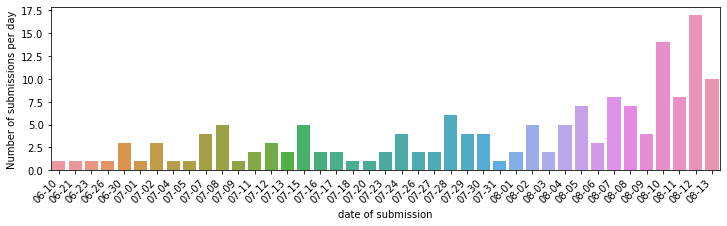

In [73]:
# Get submissions per day

## filter only submissions before deadline
filtered = df[df['timestamp'].dt.date < datetime.date(year=2021, month=8,day=14)]
days=filtered.groupby([filtered['timestamp'].dt.date]).mid.nunique().reset_index()

fig, ax = plt.subplots(figsize = (12,3), nrows=1, ncols=1)    
x_dates = filtered['timestamp'].dt.strftime('%m-%d').sort_values().unique()
fig = sns.barplot(x='timestamp', y="mid", data=days, ax=ax)
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
ax.set(xlabel='date of submission', ylabel='Number of submissions per day')
plt.savefig("imgs/submissions.pdf",bbox_inches='tight')


# Analyze improvements per languages


In [96]:
def plot_langs(data, bycol="src", name="full"):
    longdesc={"src": "Source", "trg": "Target"}
    fig_width = {"full": 21, "task1":8, "task2": 8}
    fig, ax = plt.subplots(figsize = (fig_width[name],3), nrows=1, ncols=1)    
    sorted_data= data.groupby(bycol).perf.mean().sort_values(ascending=False)
    
    sns.barplot(data=data,x=bycol,y='perf',order=sorted_data.index, palette="crest")
    ax.set_xticklabels(labels=sorted_data.index, rotation=90, ha='right')
    ax.set(xlabel=f'{longdesc[bycol]} language', ylabel='delta in spBLEU')
    plt.savefig(f"imgs/analysis_{name}_langs_by_{bycol}.pdf",bbox_inches='tight')

    #fig.show()
               
        
def analyze_task(task):
    deltas = (
    #get delta of performance between highest and baseline
    df[df.mid.isin(allp[task])].groupby(['src','trg','mid']).perf.mean().reset_index().groupby(['src','trg']).perf.max()
        - df[df.mid.isin(baselines[task])].groupby(['src','trg']).perf.mean()

    ).reset_index()
    
    ################
    print("""***Analysis of language pairs deltas***""") 
    sorted_delta = deltas.sort_values(by='perf', ascending=False)
    print ("TOP 5 improvements wrt to baseline")
    print(sorted_delta[:5] )
    print(sorted_delta[:5].to_latex(index=False) )
    print ("BOTTOM 5 improvements wrt to baseline")
    print(sorted_delta[-5:] )
    print(sorted_delta[-5:].to_latex(index=False) )
    print(f"GAP between top and bottom by pair: {list(sorted_delta.reset_index().perf)[0] -  list(sorted_delta.reset_index().perf)[-1]}" )
    
    print('AVG improv', deltas.perf.mean())
    print('AVG improv into ENG', deltas[deltas.trg=='eng'].perf.mean())
    
    print("""***Analysis per of averages source language***""")
    sorted_delta = deltas.groupby('src').mean().sort_values(by='perf', ascending=False)
    print ("TOP 5 improvements wrt to baseline")
    print(sorted_delta[:5] )
    print(sorted_delta[:5].to_latex() )

    print ("BOTTOM 5 improvements wrt to baseline")
    print(sorted_delta[-5:] )
    print(sorted_delta[-5:].to_latex() )
    
    print(f"GAP between top and bottom by source: {list(sorted_delta.reset_index().perf)[0] -  list(sorted_delta.reset_index().perf)[-1]}" )

        
    print("""Analysis of averages per target language""")
    sorted_delta=deltas.groupby('trg').mean().sort_values(by='perf', ascending=False)
    print ("TOP 5 improvements wrt to baseline")
    print(sorted_delta[:5])
    print(sorted_delta[:5].to_latex() )
    print ("BOTTOM 5 improvements wrt to baseline")
    print(sorted_delta[-5:])
    print(sorted_delta[-5:].to_latex() )
    print(f"GAP between top and bottom by trg: {list(sorted_delta.reset_index().perf)[0] -  list(sorted_delta.reset_index().perf)[-1]}" )

    plot_langs(deltas, bycol="src", name=task )
    plot_langs(deltas, bycol="trg", name=task)
    return deltas
    

               

## Full task analysis

***Analysis of language pairs deltas***
TOP 5 improvements wrt to baseline
      src  trg  perf
1832  eng  cym 46.41
2442  gle  eng 43.55
1841  eng  gle 43.10
5771  mlt  cym 42.88
2480  gle  mlt 41.83
\begin{tabular}{llr}
\toprule
src & trg &  perf \\
\midrule
eng & cym & 46.41 \\
gle & eng & 43.55 \\
eng & gle & 43.10 \\
mlt & cym & 42.88 \\
gle & mlt & 41.83 \\
\bottomrule
\end{tabular}

BOTTOM 5 improvements wrt to baseline
            src  trg  perf
6012        mri  luo  0.00
10143  zho_trad  kea  0.00
3851        jpn  ckb  0.00
8931        tgl  kea  0.00
5568        mar  ckb  0.00
\begin{tabular}{llr}
\toprule
     src & trg &  perf \\
\midrule
     mri & luo &  0.00 \\
zho\_trad & kea &  0.00 \\
     jpn & ckb &  0.00 \\
     tgl & kea &  0.00 \\
     mar & ckb &  0.00 \\
\bottomrule
\end{tabular}

GAP between top and bottom by pair: 46.41
AVG improv 10.59725393127548
AVG improv into ENG 17.558316831683168
***Analysis per of averages source language***
TOP 5 improvements wrt to b

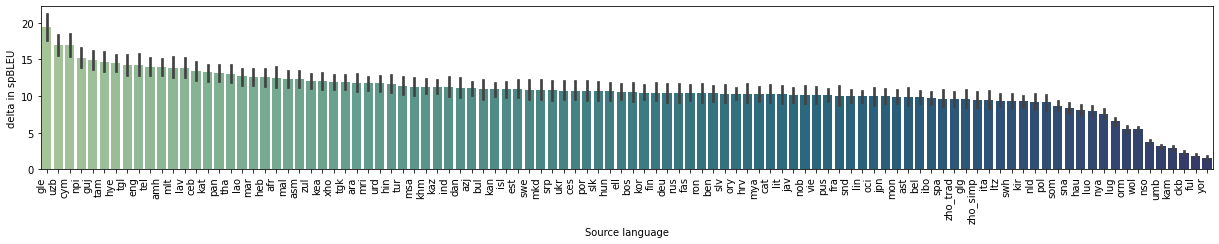

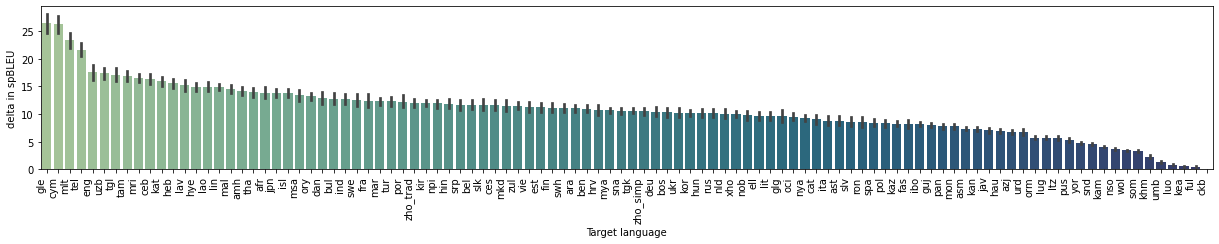

In [97]:
# full task
dd= analyze_task("full")

In [93]:
dd[(dd.src=='npi') & (dd.trg=="hin")]
dd[dd.trg=='hin'].perf.mean()

11.876633663366336

# Task 1 analysis 

***Analysis of language pairs deltas***
TOP 5 improvements wrt to baseline
    src  trg  perf
4   eng  srp 19.08
25  srp  eng 15.58
20  mkd  eng 14.81
5   est  eng 14.17
15  hun  eng 13.37
\begin{tabular}{llr}
\toprule
src & trg &  perf \\
\midrule
eng & srp & 19.08 \\
srp & eng & 15.58 \\
mkd & eng & 14.81 \\
est & eng & 14.17 \\
hun & eng & 13.37 \\
\bottomrule
\end{tabular}

BOTTOM 5 improvements wrt to baseline
    src  trg  perf
17  hun  hrv  9.05
22  mkd  hrv  8.09
13  hrv  mkd  6.96
29  srp  mkd  6.49
27  srp  hrv  6.13
\begin{tabular}{llr}
\toprule
src & trg &  perf \\
\midrule
hun & hrv &  9.05 \\
mkd & hrv &  8.09 \\
hrv & mkd &  6.96 \\
srp & mkd &  6.49 \\
srp & hrv &  6.13 \\
\bottomrule
\end{tabular}

GAP between top and bottom by pair: 12.95
AVG improv 11.318999999999997
AVG improv into ENG 13.974
***Analysis per of averages source language***
TOP 5 improvements wrt to baseline
     perf
src      
eng 14.20
mkd 11.65
est 11.43
hun 11.22
srp  9.84
\begin{tabular}{lr}
\top

,src,trg,perf
0,eng,est,12.91
1,eng,hrv,12.54
2,eng,hun,13.31
3,eng,mkd,13.15
4,eng,srp,19.08
5,est,eng,14.17
6,est,hrv,9.27
7,est,hun,10.62
8,est,mkd,10.47
9,est,srp,12.61


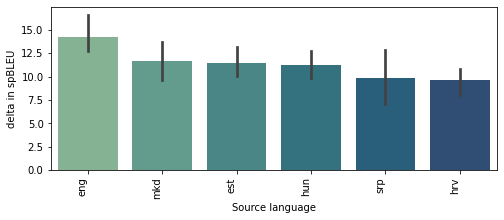

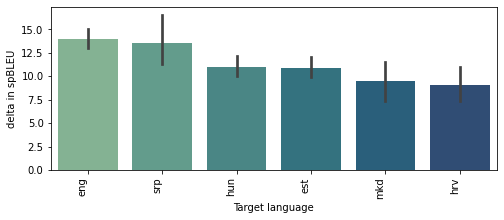

In [98]:

analyze_task("task1")

***Analysis of language pairs deltas***
TOP 5 improvements wrt to baseline
    src  trg  perf
3   eng  tam 31.15
20  tam  eng 30.86
25  tgl  eng 30.50
4   eng  tgl 28.45
8   ind  tam 27.97
\begin{tabular}{llr}
\toprule
src & trg &  perf \\
\midrule
eng & tam & 31.15 \\
tam & eng & 30.86 \\
tgl & eng & 30.50 \\
eng & tgl & 28.45 \\
ind & tam & 27.97 \\
\bottomrule
\end{tabular}

BOTTOM 5 improvements wrt to baseline
    src  trg  perf
27  tgl  jav 15.63
17  msa  jav 13.68
6   ind  jav 12.44
7   ind  msa 12.34
16  msa  ind 10.97
\begin{tabular}{llr}
\toprule
src & trg &  perf \\
\midrule
tgl & jav & 15.63 \\
msa & jav & 13.68 \\
ind & jav & 12.44 \\
ind & msa & 12.34 \\
msa & ind & 10.97 \\
\bottomrule
\end{tabular}

GAP between top and bottom by pair: 20.180000000000003
AVG improv 21.89966666666667
AVG improv into ENG 25.484
***Analysis per of averages source language***
TOP 5 improvements wrt to baseline
     perf
src      
tam 24.49
eng 24.12
tgl 23.54
jav 20.82
ind 19.39
\begin{tabul

,src,trg,perf
0,eng,ind,20.41
1,eng,jav,18.99
2,eng,msa,21.60
3,eng,tam,31.15
4,eng,tgl,28.45
5,ind,eng,19.47
6,ind,jav,12.44
7,ind,msa,12.34
8,ind,tam,27.97
9,ind,tgl,24.74


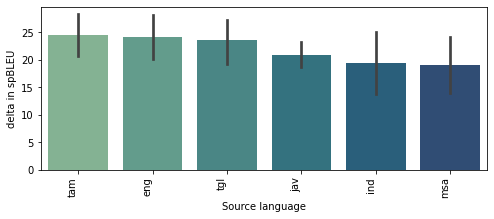

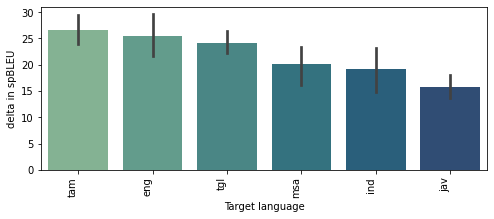

In [99]:
# task2 task
analyze_task("task2")

In [31]:
def contrast_mm(data, task='task1', bycol='src'):
    longdesc={"src": "Source", "trg": "Target"}
    fig_width = {"full": 21, "task1":8, "task2": 8}
    fig, ax = plt.subplots(figsize = (fig_width[task],3), nrows=1, ncols=1)    
    comparison=data[(data.mid.isin(winners['full']+winners[task]) ) & (data.src.isin(languages[task]) ) & (data.trg.isin(languages[task]) )]
    sorted_data= comparison.groupby(bycol).perf.mean().sort_index(ascending=True)

    sns.barplot(data=comparison, x=bycol, y="perf", hue="taskname")
    ax.set_xticklabels(labels=sorted_data.index, rotation=45, ha='right')

    ax.set(xlabel=f'{longdesc[bycol]} language', ylabel='Winning model spBLEU')
    plt.legend(title='Shared Task')
    plt.savefig(f"imgs/analysis_full_vs_{task}_contrast_by_{bycol}.pdf",bbox_inches='tight')

def analyze_contrast(task):
    contrast_mm(df,task, "src")
    contrast_mm(df,task, "trg")
    

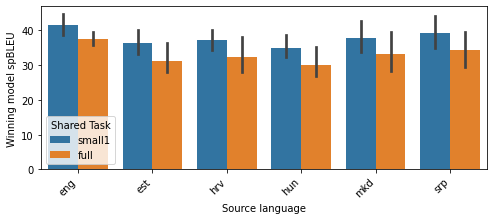

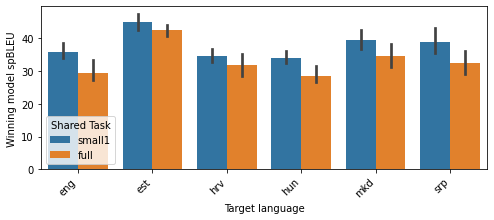

In [32]:

analyze_contrast("task1")

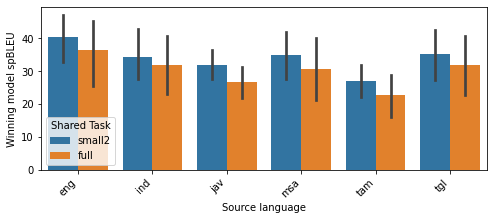

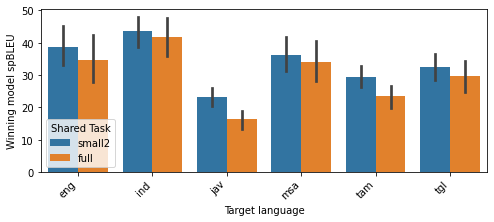

In [33]:
analyze_contrast("task2")